# **Sommario**
**Step 1: Raccolta dei dati**
* CSV dataset ✓ (kaggle job dataset 1.2M+ ennuple https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024).
* Importare csv in python con Pandas (selezionare solo le colonne utili) ✓

**Step 2: Preprocessing dei dati (per tutto il dataset)**
* Pulizia dei dati ✓
* Tokenizzazione ✓
* Rimozione delle stop words ✓
* Stemming o Lemmatization ✓

**Step 3: Feature Extraction**
* Bag of Words (BoW) oppure TF-IDF ✓
* Word Embeddings: Utilizzare tecniche come Word2Vec o GloVe per ottenere rappresentazioni dense delle parole (opzionale).

**Step 4: Riduzione di dimensinoalità**
* Principal Component Analisys (PCA)

**Step 5: Creazione del Modello**
* Dividere il dataset in set di addestramento e di test. ✓
* Modelli Classici: Random Forest, SVM, Logistic Regression. -> **classificatore multi-label per ogni skill** ✓
* Deep Learning: Reti neurali ricorrenti (RNN), LSTM, Transformer.

**Step 6: Addestramento del Modello**
* Addestrare il modello sui dati di addestramento.
* Valutare le prestazioni sui dati di test.

**Step 7: Valutazione del Modello**\
* Utilizzare metriche di valutazione appropriate per giudicare l'efficacia del modello, come precision, recall, F1-score.

# **Metodi utilizzati nel notebook**

Metodo per il pre-processing del testo

In [1]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download dei dataset necessari per nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Definizione delle stop words e inizializzazione del lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing
def preprocess(text):
    # Pulizia del testo
    text = re.sub(r"[^a-zA-Z\s]", '', text) # Rimozione di stringhe composte solo da caratteri speciali e/o numeri
    text = re.sub(r'\(.*?\)', '', str(text)).lower().replace(',', '').replace('  ', ' ') # Rimozione del contenuto tra parentesi
    # Tokenizzazione
    tokens = nltk.word_tokenize(text)
    # Stopping
    tokens = [w for w in tokens if w not in stop_words]
    # Lemmatizzazione
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

def preprocess_skills(text):
    # Pulizia del testo
    text = str(text).replace('"','').replace("'",'').strip("[]") # Rimozione di virgolette e parentesi
    text = text.lower()
    text = re.sub(r',\s*[^\w\s][^,]*|,\s*\d[^,]*', '', text) # Rimozione di sottostringhe delimitate da virgole che iniziano con un numero o carattere speciale
    # Tokenizzazione
    tokens = text.split(',')
    tokens = [token.replace('  ',' ') for token in tokens] # Rimozione dei doppi spazi dopo lo split
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Metodo per l'individuazione delle etichette rappresentative di un cluster

In [2]:
from sklearn.metrics.pairwise import euclidean_distances

# Definizione funzione per etichette rappresentative
def find_representative_skill(cluster_index, centroids, embedded_labels):
    # Seleziona solo le skill del cluster corrente
    cluster_skills = embedded_labels[embedded_labels['cluster'] == cluster_index]
    # Calcola le distanze tra ogni skill e il centroide del cluster
    distances = euclidean_distances(cluster_skills.iloc[:, :-2], centroids[cluster_index].reshape(1, -1))
    # Argmin restituisce l'indice della skill più vicina al centroide
    closest_skill_index = np.argmin(distances)
    # Restituisce il nome della skill rappresentativa
    return cluster_skills.iloc[closest_skill_index]['skill']

Metodo per sostituire le skill nella lista con quelle rappresentative del cluster a cui appartengono

In [3]:
# Funzione per sostituire le skill nella lista con quelle rappresentative
def replace_with_representative_skills(skills):
    return list(set([skill_to_representative_map.get(skill, skill) for skill in skills]))

Metodo per il calcolo del vettore medio di embedding

In [4]:
from gensim.models import Word2Vec
import numpy as np

# Definisco la funzione di calcolo dell'embedding per una descrizione, cioè la media tra i vettori di embedding di ogni termine
def get_average_word2vec(tokens_list, model, vector_size):
    if len(tokens_list) < 1:
        return np.zeros(vector_size)
    vector = np.mean([model[token] for token in tokens_list if token in model] or [np.zeros(vector_size)], axis=0)
    return vector

# **Step 1: Raccolta dei dati**

In [5]:
# Importazione librerie
import pandas as pd
import joblib
import pickle

percorso_locale = 'D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/' # Percorso locale (cartella in cui è contenuto il dataset e in cui sarà salvato il modello)
#percorso_locale = '/mnt/data/ML/' # Percorso nel volume Docker
percorso_cloud = '/content/drive/MyDrive/ColabFiles/' # Percorso del drive

In [ ]:
pd.set_option('display.max_columns', None)  # Mostra tutte le colonne
pd.set_option('display.max_rows', None)     # Mostra tutte le righe
pd.set_option('display.max_colwidth', None)  # Mostra l'intero contenuto delle celle

In [ ]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

```
# Importazione dei dataset di offerte e di skills utilizzando Pandas
descriptions_df = pd.read_csv(percorso_locale+'job_summary.csv')
skills_df = pd.read_csv(percorso_locale+'job_skills.csv')

# Unione dei csv sulla base della colonna 'job_link'
data = descriptions_df.merge(skills_df, on='job_link')

# Pulizia del datafame
import numpy as np
data.replace('', np.nan, inplace=True) # Sostituisci eventuali stringhe vuote con valori nulli
data.dropna(how='any') # Elimina una riga che ha anche solo un valore nullo

data.head()

# Salvataggio del dataset
data.to_csv(percorso_locale+'job_descriptions_and_skills.csv')
```

In [6]:
# Importazione del dataset utilizzando Pandas
data = pd.read_csv(percorso_locale+'job_descriptions_and_skills.csv', usecols=['job_skills', 'job_summary'])

# Cambio nome delle colonne interessate in un dataframe Pandas
data.rename(columns={'job_skills':'skills', 'job_summary':'description'}, inplace = True)

# Visualizza le prime righe del DataFrame
data.head()

,description,skills
0,Rock N Roll Sushi is hiring a Restaurant Manag...,"Restaurant Management, Food and Beverage Knowl..."
1,Schedule\n: PRN is required minimum 12 hours p...,"Registered Nurse, Patient Care, Nursing, Healt..."
2,Description\nIntroduction\nAre you looking for...,"Registered Nurse, Cath Lab, Intentional Radiol..."
3,Commercial account executive\nSheffield\nFull ...,"Business Development, Communication, Client Re..."
4,Address:\nUSA-CT-Newington-44 Fenn Road\nStore...,"Customer service, Communication skills, Leader..."


# **Step 2.1: Preprocessing dei dati - Elaborazione del testo**

Applicazione del metodo di preprocessing

In [7]:
# Applicazione della funzione di preprocessing creando una nuova colonna nel dataFrame per le descrizioni
data['description'] = data['description'].apply(preprocess)
print(data['description'])

# Applicazione della funzione di preprocessing creando una nuova colonna nel dataFrame per le skills
data['skills'] = data['skills'].apply(preprocess_skills)
print(data['skills'])

0          rock n roll sushi hiring restaurant manager re...
1          schedule prn required minimum hour per period ...
2          description introduction looking place deliver...
3          commercial account executive sheffield full ti...
4          address usactnewington fenn road store code s ...
                                 ...                        
1296376    company description job humanity partnering gr...
1296377    job description general manager responsible dr...
1296378    location austin tx salary usd annually usd ann...
1296379    company description job humanity partnering gr...
1296380    description benefit perk need family benefit p...
Name: description, Length: 1296381, dtype: object
0          [restaurant management,  food and beverage kno...
1          [registered nurse,  patient care,  nursing,  h...
2          [registered nurse,  cath lab,  intentional rad...
3          [business development,  communication,  client...
4          [customer service,  comm

Criticità:
* Lo stemmer commette diversi errori -> si utilizza la Lemmatizzazione (approccio a dizionario) al suo posto;
* Il processo non è in grado di unire parole composte in token unici (es. *'social network'* viene erroneamente tokenizzato come *'social', 'network'*).

In [8]:
# Salvataggio del dataset preprocessato
data.to_pickle(percorso_locale+'data.pkl')

# **Step 2.2: Preprocessing dei dati - Gestione delle etichette**

**Importazione e analisi delle etichette**

In [7]:
# Importazione del dataset già preprocessato
data = pd.read_pickle(percorso_locale+'data.pkl')

In [8]:
# Controllo della composizione dell'insieme delle etichette
all_skills = [skill for sublist in data['skills'] for skill in sublist]
skills_df = pd.DataFrame(all_skills, columns=['skill'])
label_counts = skills_df['skill'].value_counts()

all_present_labels = label_counts[label_counts == len(data)]
too_common_labels = label_counts[label_counts > 0.95 * len(data)]
too_rare_labels = label_counts[label_counts < 0.01 * len(data)]

print(f"Numero di skills presenti in tutte le descrizioni: {len(list(all_present_labels.index))}")
print(f"Numero di skills troppo comuni (>95%): {len(list(too_common_labels.index))}")
print(f"Numero di skills troppo rare (<1%): {len(list(too_rare_labels.index))}")

# Percentuale di appartenenza alle descrizioni per ogni etichetta
label_percentages = (label_counts / len(data)) * 100
print(f"\nSkill|% di apparizione: \n{label_percentages}")

Numero di skills presenti in tutte le descrizioni: 0
Numero di skills troppo comuni (>95%): 0
Numero di skills troppo rare (<1%): 2745962

Skill|% di apparizione: 
 communication                                                                                              27.627218
 teamwork                                                                                                   17.307643
 customer service                                                                                           15.327747
 communication skills                                                                                       14.108198
 leadership                                                                                                 12.624221
                                                                                                              ...    
 experience working with external clients on operational services within mmis account                        0.000077
 bachelors

Il numero di etichette è estremamente elevato e sparso, sarà necessario diminuirne il numero e la sparsità aggregando etichette simili effettuando un clustering basato sulle co-occorrenze delle skills stesse oppure sui loro valori di embedding.

In [9]:
# Calcola la frequenza delle skill
skill_freq = data['skills'].apply(lambda x: [skill for skill in x if label_counts[skill] == 1])

# Calcola la percentuale di skill uniche per ogni riga
unique_skill_pct = skill_freq.apply(lambda x: len(x) / len(data['skills'].iloc[0]))

# Scarta le righe con più della metà delle skill uniche
data = data[unique_skill_pct < 0.5]

**Embedding delle etichette**

In [10]:
import gensim

skills_list = data['skills'].tolist() # é una lista di liste, ogni lista interna è l'elenco delle skill di una riga
skills_set = set([skill for list in skills_list for skill in list]) # Isolo le skill presenti nelle liste # è un set contenente tutte le skill senza ripetizioni
single_skills = [skill.split() for skill in skills_set] # è una lista di liste, ogni lista interna è l'elenco delle parole di una skill

# Definizione del modello w2v per le etichette
# w2v_model = Word2Vec(single_skills, vector_size=100, window=5, min_count=1, workers=4)
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(percorso_locale+'w2v_model.bin', binary=True)

In [11]:
embedded_labels = pd.DataFrame([get_average_word2vec(terms, w2v_model, w2v_model.vector_size) for terms in (single_skills)], columns=[f'ED{i+1}' for i in range(w2v_model.vector_size)])
embedded_labels['skill'] = list(skills_set) # Ad ogni riga di embedding è accodato il nome della skill di riferimento

embedded_labels.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,...,ED292,ED293,ED294,ED295,ED296,ED297,ED298,ED299,ED300,skill
0,-0.013855,0.057709,0.025848,0.065979,0.050873,-0.104004,0.049072,-0.089172,0.067688,0.052778,...,-0.072128,-0.072754,-0.015930,0.092957,-0.031799,0.089783,-0.116089,0.017044,-0.051086,proficiency in creating presentations
1,0.020996,-0.127930,0.155273,0.026367,-0.000732,-0.027832,0.096802,-0.167969,0.165192,0.158813,...,0.088623,0.106384,-0.018555,0.107239,-0.002441,-0.182129,-0.086736,-0.256836,0.003174,fl license
2,-0.088989,0.119629,-0.088196,-0.106659,-0.071899,0.192871,-0.045990,-0.079895,0.114258,0.098145,...,-0.108643,-0.193542,0.033142,-0.131348,-0.064697,0.074097,-0.099854,0.061523,-0.113770,plastics knowledge
3,-0.242513,0.330404,0.068990,0.153809,-0.334310,0.162923,0.234273,0.003011,-0.134816,-0.032328,...,0.007650,-0.038900,-0.165365,-0.071452,-0.042191,-0.050822,0.130941,0.175456,0.204753,congenital heart cath
4,0.042847,0.049707,-0.145923,0.065698,-0.055029,0.093726,-0.044263,-0.192188,0.245508,0.008789,...,-0.082654,-0.051685,-0.054034,0.034570,0.064172,0.028235,-0.016260,0.029362,0.001245,disaster recovery and business continuity pla...


In [12]:
embedded_labels.to_pickle(percorso_locale+'embedded_labels.pkl')

In [ ]:
embedded_labels = pd.read_pickle(percorso_locale+'embedded_labels.pkl')

**Clustering delle etichette embeddate**

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_min, k_max, passo = 400, 600, 20

# Determina il numero ottimale di cluster
inertia = []
for k in range(k_min, k_max, passo):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1).fit(embedded_labels.iloc[:, :-1]) #-1 perchè nell'ultima riga del dataframe c'è il nome della skill
    inertia.append(kmeans.inertia_)
plt.plot(list(range(k_min, k_max)), inertia)
plt.xlabel('Numero di cluster')
plt.ylabel('Inertia')
plt.show()

In [13]:
from sklearn.cluster import KMeans

clusters = 600 #Numero di cluster scelto in base al numero di classi e in base al numero di esempi di training

# Definizione del modello di clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(embedded_labels.iloc[:, :-1]) #Passare la matrice delle co-occorrenze al posto di "embedded_labels" per clusterizzare secondo l'altro criterio

# Salvataggio del modello di clustering k-means
joblib.dump(kmeans, percorso_locale+'base/kmeans.joblib')

['D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/base/kmeans.joblib']

In [ ]:
for cluster in range(0,kmeans.n_clusters):
    print("cluster ",cluster)
    embedded_labels.apply(lambda x:print(f"skill: {x['Skill']}") if x['cluster'] == cluster else None, axis=1)
    print('\n')

In [14]:
kmeans = joblib.load(percorso_locale+'base/kmeans.joblib')

# Etichette dei cluster
cluster_labels = kmeans.labels_

# Ad ogni skill embeddada viene aggiunto il numero del cluster al quale è stata associata
embedded_labels['cluster'] = cluster_labels

**Definizione delle etichette rappresentative**

In [15]:
# Centroidi dei cluster per etichette rappresentative
centroids = kmeans.cluster_centers_

# Crea una mappa per sostituire le etichette originali con quelle rappresentative(piu vicine ai centroidi)
cluster_to_label_map = {i: find_representative_skill(i,centroids,embedded_labels) for i in range(kmeans.n_clusters)}

# Stampa le etichette rappresentative dei cluster
print(cluster_to_label_map)

# Crea una mappa tra ogni skill e la sua skill rappresentativa
skill_to_representative_map = embedded_labels.set_index('skill')['cluster'].map(cluster_to_label_map).to_dict()

{0: ' tax knowledge (h&r block tax knowledge assessment or income tax course (if preparing tax returns) and 3 hours of tax update)', 1: ' uhd', 2: ' product or hospital sales experience in oncology nephrology dermatology rheumatology inflammation cardiology neurology endocrinology hepatology gastroenterology or infectious diseases', 3: ' experience in problemsolving and attention to detail', 4: ' ability to work in a moderate to occasionally loud noise level', 5: ' nbhwc certification', 6: ' bayesian analytics', 7: ' jhu standards', 8: ' one year of experience in public health health services research health care quality improvement epidemiology or health outcomes research', 9: ' specialization in wealth management banking and consumer finance or corporate finance.', 10: ' microsoft .net', 11: 'qsr industry experience', 12: ' epm (enterprise performance management)', 13: ' problemsolving and customer service', 14: ' aerodigestive program', 15: ' business unit design standards and speci

**Sostituzione delle etichette con l'etichetta rappresentativa del cluster a cui appartengono**

In [16]:
# Sostituisci le skill nella colonna originale
data['aggregated_skills'] = data['skills'].apply(replace_with_representative_skills)

In [17]:
# Controllo della composizione dell'insieme delle etichette dopo il clustering
all_skills = [skill for sublist in data['aggregated_skills'] for skill in sublist]
skills_df = pd.DataFrame(all_skills, columns=['aggregated_skills'])
label_counts = skills_df['aggregated_skills'].value_counts()

all_present_labels = label_counts[label_counts == len(data)]
too_common_labels = label_counts[label_counts > 0.95 * len(data)]
too_rare_labels = label_counts[label_counts < 0.01 * len(data)]

print(f"Numero di skills presenti in tutte le descrizioni: {len(list(all_present_labels.index))}")
print(f"Numero di skills troppo comuni (>95%): {len(list(too_common_labels.index))}")
print(f"Numero di skills troppo rare (<1%): {len(list(too_rare_labels.index))}")

# Percentuale di appartenenza alle descrizioni per ogni etichetta
label_percentages = (label_counts / len(data)) * 100
print(f"\nSkill|% di apparizione: \n{label_percentages}")

Numero di skills presenti in tutte le descrizioni: 0
Numero di skills troppo comuni (>95%): 0
Numero di skills troppo rare (<1%): 166

Skill|% di apparizione: 
 strong communication interpersonal and problemsolving skills    35.969091
 interprocessor communication                                    35.782301
 uhd                                                             33.166807
 problemsolving and customer service                             28.129487
 noshow management                                               26.322202
                                                                   ...    
 icbo codes                                                       0.161914
 agglutination assays                                             0.147904
 neebosh qualification                                            0.141961
 mlr process                                                      0.137461
 section 106 of the nhpa                                          0.106810
Name: aggregate

# **Fase 3: Feature Extraction**

**Binarizzazione delle etichette clusterizzate**

In [18]:
# Importazione e inizializzazione del binarizzatore
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Binarizzazione delle etichette aggregate in un dataFrame Pandas
labels = pd.DataFrame(mlb.fit_transform(data['aggregated_skills']), columns=mlb.classes_)

# Salvataggio del binarizzatore
joblib.dump(mlb, percorso_locale+'base/mlb.joblib')

labels.head()

,ability to adapt to business changes with the ability to influence others,ability to be respectful approachable and team oriented,ability to climb stairs ladders and work from heights,ability to complete service requests and work orders,ability to fulfill activities including but not limited to remain stationary for extended periods of time (i.e. while working at a desk standing on sidelines) stoop/kneel/crouch travel around the location communicate with others (verbal and written) and use fine motor skills including fine hand manipulation and,ability to help create an educational environment supportive of staff students and faculty inclusive of race culture (dis)ability gender sexuality religion or other aspects of human diversity,ability to lift file boxes onto and off of shelving in storage rooms,ability to lift or move up to 20 pounds,ability to model company values of respect integrity teamwork compassion accountability and inclusivity,ability to perform physical tasks such as standing sitting walking reaching pushing pulling lifting bending stooping squatting kneeling and twisting,...,it supplier management,lead from the front,medicalsurgical registered nurse (med surg rn),mep contract management,mep inspection,multiaxis millturn operator,qsr industry experience,registered nurse level i ii iii or iv,rn asn,six sigma or lean six sigma blackbelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Vettorizzazione dei dati di training**

```
# Importazione e inizializzazione del vettorizzatore per TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Calcolo dei valori TF-IDF in un DataFrame
# La matrice sparsa viene convertita in un vettore denso prima di creare il dataFrame
tfIdf_array = vectorizer.fit_transform(data['description']).toarray()
tfIdf = pd.DataFrame(tfIdf_array, columns=vectorizer.get_feature_names_out())

# Salvataggio del vettorizzatore
joblib.dump(vectorizer, percorso_locale+'base/vectorizer.joblib')

tfIdf.head()
```

**Embedding delle parole**

In [19]:
description_list = data['description'].tolist() #.apply(lambda x: [str(x).split()]) per dividere la colonna description in liste di liste, dove ciascuna lista corrisponde ad una descrizione, ongi lista interna contiene un token e la lista esterna contiene tutti i token della descrizione

# print(description_list)
# Definisco il modello word2vec sulle descrizioni
# (vector_size=numero di caratteristiche latenti dei termini esaminate; Window: numero max di parole a sinistra e a destra utilizzate per addestrare l'embedding; min_count=
# numero minimo di occorenze che deve avere un termine per essere preso in considerazione; workers= numero di thread)
# w2v_model = Word2Vec(description_list, vector_size=100, window=5, min_count=1, workers=4)

In [20]:
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(percorso_locale+'w2v_model.bin', binary=True)

In [21]:
embedded_desc = pd.DataFrame(data['description'].apply(str).apply(lambda x: get_average_word2vec(x.split(), w2v_model, w2v_model.vector_size)).tolist(), columns=[f'ED{i+1}' for i in range(w2v_model.vector_size)])

embedded_desc.head()

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,...,ED291,ED292,ED293,ED294,ED295,ED296,ED297,ED298,ED299,ED300
0,-0.063789,0.017269,-0.001017,0.061306,-0.035866,0.019912,0.058242,-0.072214,0.078327,0.036929,...,-0.070980,0.071204,-0.074001,0.066337,0.004070,0.008814,0.035987,-0.039895,0.022012,-0.023403
1,-0.037679,0.019413,-0.007495,0.050774,-0.069603,0.033068,0.071067,-0.056408,0.076085,-0.028287,...,-0.090850,0.013224,-0.051011,0.008326,-0.030578,0.068123,0.017085,-0.004915,0.009481,0.008904
2,-0.043164,0.022990,0.006323,0.067321,-0.010008,0.030345,0.073443,-0.079760,0.084093,-0.046365,...,-0.067775,0.032588,-0.093648,0.005587,-0.012599,0.070383,0.000412,0.003986,0.036800,0.000409
3,-0.030671,0.001777,-0.022532,0.025002,-0.023681,-0.012908,0.074671,-0.044164,0.094156,0.021972,...,-0.048846,0.073812,-0.083982,-0.003646,-0.026736,0.033376,0.038569,-0.039956,-0.018605,-0.048966
4,-0.033606,0.015543,0.003431,0.025792,-0.051518,-0.011901,0.062601,-0.061273,0.080392,0.032058,...,-0.065932,0.063824,-0.078341,0.007863,-0.042683,0.042464,0.045756,-0.017055,0.022083,-0.016762


In [22]:
embedded_desc.to_pickle(percorso_locale+'embedded_desc.pkl')

In [ ]:
embedded_desc = pd.read_pickle(percorso_locale+'embedded_desc.pkl')

De-allocazione dei dataframe non più necessari

In [23]:
# De-allocazione del dataFrame data in quanto non più necessario
import gc
del data
del embedded_labels
gc.collect()

42

# **Step 4: Riduzione di dimensionalità**

**Individuazione del numero ottimale di componenti principali**

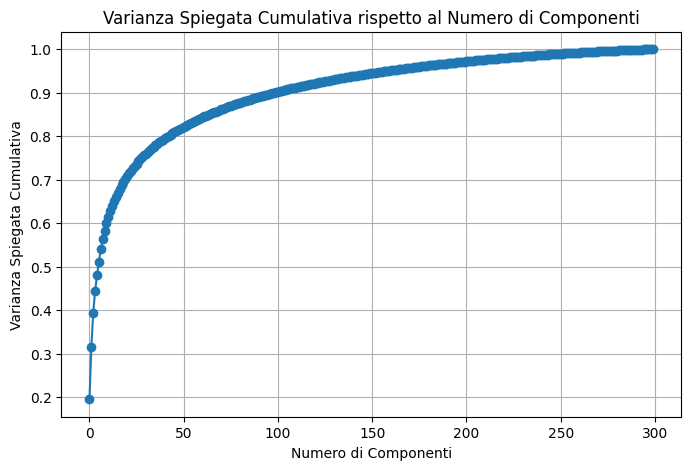

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Inizializzare e fit di PCA senza specificare il numero di componenti
pca = PCA()
pca.fit(embedded_desc)

# Calcolare la varianza spiegata cumulativa
explained_variance = pca.explained_variance_ratio_.cumsum() #.to_array()

# Plot della varianza spiegata cumulativa
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata Cumulativa rispetto al Numero di Componenti')
plt.grid(True)
plt.show()

**Calcolo delle componenti principali**

In [25]:
# Definizione del numero ottimale di componenti dello spazio di destinazione
pc = np.where(explained_variance >= 0.9)[0][0] + 1 # Preleviamo il numero minimo di componenti per spiegare il 90% della varianza

# Inizializzazione e fit del riduttore di dimensionalità
pca = PCA(n_components=pc)
embedded_desc_reduced = pd.DataFrame(pca.fit_transform(embedded_desc), columns=[f'PC{i+1}' for i in range(pc)])

# Salvataggio del riduttore
joblib.dump(pca, percorso_locale+'base/pca.joblib')

embedded_desc_reduced.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99
0,-0.006931,-0.107395,0.174944,0.054898,0.130093,-0.074472,0.011032,0.085332,-0.058541,0.043386,...,-0.005442,-0.004581,-0.009105,0.011101,0.005017,-0.003856,-0.005843,-0.000174,-0.008157,0.003245
1,-0.037251,0.160112,-0.147692,0.071451,0.080330,-0.054179,0.063109,-0.047887,-0.000501,0.037760,...,-0.011767,-0.000569,0.001898,-0.003605,-0.003915,0.009440,0.002203,0.005466,-0.023179,0.003919
2,-0.061975,0.281463,-0.060543,-0.040789,0.041635,0.027447,-0.100234,0.005789,0.052670,-0.008693,...,0.005587,0.007322,0.009977,-0.000566,-0.002105,-0.005514,0.004185,-0.007227,-0.008171,0.001371
3,-0.028430,-0.087975,0.100985,-0.012701,-0.067213,-0.064397,-0.010745,-0.081086,-0.024823,0.013497,...,0.004267,-0.006153,-0.004857,-0.010136,0.000704,0.017576,0.009814,0.009146,-0.007842,-0.003245
4,-0.067745,-0.075040,-0.005751,-0.047080,0.022233,-0.139680,0.014912,0.040139,0.063365,0.041174,...,-0.006928,-0.010444,-0.001397,-0.012294,-0.008362,0.007622,0.007903,-0.021153,0.004386,0.012309


# **Step 5: Creazione del Modello**

**Split del dataset**

In [26]:
from sklearn.model_selection import train_test_split as train_test_split

# Dividere in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(embedded_desc_reduced, labels, test_size=0.2, random_state=42)

In [27]:
# Salva i dati
joblib.dump((X_train, X_test, y_train, y_test), percorso_locale + 'base/train_test_split.joblib')

['D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/base/train_test_split.joblib']

In [ ]:
# Carica i dati
X_train, X_test, y_train, y_test = joblib.load(percorso_locale + 'base/train_test_split.joblib')

Il primo argomento di 'train_test_split' è il set di dati (descrizioni), il secondo argomento è il set di etichette ad essi associate (skills).

Si tiene traccia delle corrispondenze tra dati ed etichette tramite gli indici del dataFrame, che devono coincidere.

**K-fold Cross Validation**

In [ ]:
# Definizione della cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Utilizzo K-fold
for train_index, test_index in kf.split(embedded_desc_reduced):
    X_train, X_test = embedded_desc_reduced.iloc[train_index], embedded_desc_reduced.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

**Definizione del modello**

Utilizziamo un classificatore multi-etichetta utilizzando la tecnica One-versus-Rest. Questo approccio addestra un classificatore binario per ogni etichetta per determinare se una certa etichetta deve essere assegnata o meno ad una descrizione.

In [28]:
# Importazione librerie per la classificazione binaria e OvR
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Inizializzare il modello multi-label con OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=200))

# **Step 6: Addestramento del modello**

In [29]:
# Addestramento del modello sui dati di addestramento
model.fit(X_train, y_train)

# Salvataggio del modello
joblib.dump(model, percorso_locale + 'base/model.joblib')

['D:/Users/Davide/Documents/Scuola/Uni/Magistrale/Primo Anno/ML/base/model.joblib']

Curve di apprendimento

In [ ]:
import matplotlib.pyplot as plt

# Stampa le curve di apprendimento
plt.plot(history.history['loss'], label='Loss di addestramento')
plt.plot(history.history['val_loss'], label='Loss di validazione')
plt.plot(history.history['accuracy'], label='Accuratezza di addestramento')
plt.plot(history.history['val_accuracy'], label='Accuratezza di validazione')
plt.title('Curve di Apprendimento')
plt.xlabel('Epoche')
plt.ylabel('Valore')
plt.legend(loc='best')
plt.show()

# **Step 7: Valutazione del modello**

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Predizione
y_pred = model.predict(X_test)

# Valutazione dell'accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Report di classificazione
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Accuracy: 0.0002929214885505905


d:\Anaconda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


d:\Anaconda\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Esempio di utilizzo**

In [28]:
import gensim
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Caricare il modello e il vettorizzatore salvati
model = joblib.load(percorso_locale + 'base/model.joblib')
#vectorizer = joblib.load(percorso_locale + 'base/vectorizer.joblib')
pca = joblib.load(percorso_locale+'base/pca.joblib')
mlb = joblib.load(percorso_locale+'base/mlb.joblib')
w2v = gensim.models.KeyedVectors.load_word2vec_format(percorso_locale+'w2v_model.bin', binary=True)

# Input testo
stringa = "web developer"

# Pulizia testo
stringa_clean = preprocess(stringa)

# Vettorizzazione testo
#stringa_tfIdf = vectorizer.transform([stringa_clean])

# Embedding dell'input
stringa_embedded = get_average_word2vec(stringa_clean, w2v, w2v.vector_size)
stringa_embedded = stringa_embedded.reshape(1, -1)  # Aggiungi una dimensione per batch

# Estrazione componenti principali testo (PCA)
stringa_PCs = pca.transform(stringa_embedded.toarray())

# Predizione
prediction= model.predict(stringa_PCs)

# Stampa
print('List of required skills: ' + str(mlb.inverse_transform(prediction)))

ValueError: invalid literal for int() with base 0: b'\xbf\x17S\x0c\x96\t)\x97f\x1a\xd6J\x0e\xb8X\x03\x00\x00\x00posq*M\x00\x01uX\t\x00\x00\x00has_gaussq+K\x00X\x05\x00\x00\x00gaussq,G\x00\x00\x00\x00\x00\x00\x00\x00ubX\x02\x00\x00\x00hsq-K\x00X\x08\x0